In [14]:
## load libraries ####
rm(list=ls())
library("dplyr")
library("ggplot2")
library("xtable")
library("pheatmap")
library("RColorBrewer")
library("Seurat")
library("Matrix")
library("DT")
library("alakazam")


## QC check based on BCR and GEX data directly from CellRanger

In [15]:
path.data.root = file.path("D:","Storage", "MaryT2",  "raw")

samples = c("P1_skin_a", "P1_skin_c", "P2_skin_a", "P2_skin_c")
obj_list <- list()
barcode.GEX.list <- list()
barcode.BCR.list <- list()
gene_use=c()

for(sample in samples){
    cat(sample, '\n')    
    # Read in GEX data
    path.data = file.path(path.data.root, paste0("GEX_",sample))
    data <- Read10X(data.dir =path.data)
    #colnames(data) <- sapply(colnames(data), function(x) paste(sample, x, sep = '_'))
    obj <- CreateSeuratObject(counts = data, project = sample)
    obj$sampleName <- sample
    obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    obj_list[[sample]] = obj # read in all GEX data to a list
    barcode.GEX.list[[sample]] = unlist(lapply(strsplit(as.character(unique(Cells(obj))),"-"),function(x) x[1]))
    
    # Read in BCR data
    path.data.BCR = file.path(path.data.root, paste0("BCR_", sample),"filtered_contig_annotations.txt")
    data.BCR = read.delim(file = path.data.BCR)
    barcode.BCR.list[[sample]] = unlist(lapply(strsplit(as.character(data.BCR$barcode),"-"),function(x) x[1]))
}

P1_skin_a 
P1_skin_c 
P2_skin_a 
P2_skin_c 


In [16]:
# Check overlap of cell barcodes
options(repr.plot.width=4, repr.plot.height=4)
GEX.matrix = matrix(nrow=length(samples), ncol=length(samples))
colnames(GEX.matrix) = samples
rownames(GEX.matrix) = samples
BCR.matrix = matrix(nrow=length(samples), ncol=length(samples))
colnames(BCR.matrix) = samples
rownames(BCR.matrix) = samples
GEX.BCR.matrix = matrix(nrow=length(samples), ncol=length(samples))
colnames(GEX.BCR.matrix) = samples
rownames(GEX.BCR.matrix) = samples
for(i in 1:length(samples)){
    for(j in 1:length(samples)){
            GEX.matrix[i,j] = length(intersect(barcode.GEX.list[[samples[i]]], barcode.GEX.list[[samples[j]]]))
            BCR.matrix[i,j] = length(intersect(barcode.BCR.list[[samples[i]]], barcode.BCR.list[[samples[j]]]))
            GEX.BCR.matrix[i,j] = length(intersect(barcode.GEX.list[[samples[i]]], barcode.BCR.list[[samples[j]]]))
        }
}

### Overlap of cell barcodes among samples in GEX

P1_skin_a P1_skin_c P2_skin_a P2_skin_c
P1_skin_a 9598       104        157      125     
P1_skin_c  104      8609        152      114     
P2_skin_a  157       152      12303      161     
P2_skin_c  125       114        161     9456

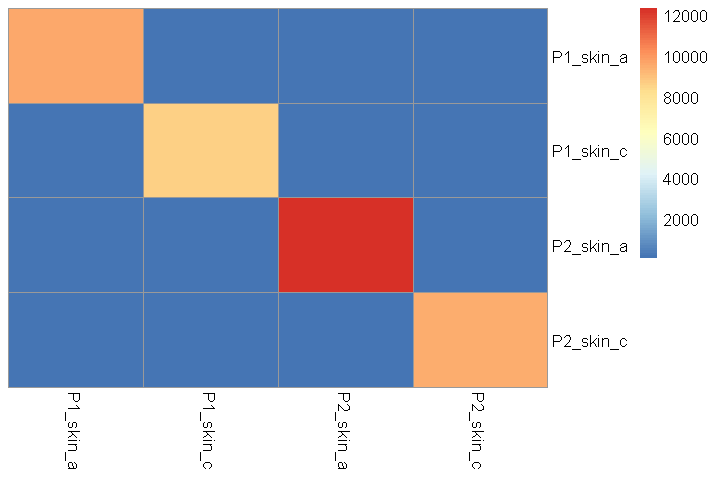

In [17]:
GEX.matrix
options(repr.plot.width=6, repr.plot.height=4)
pheatmap(GEX.matrix, cluster_rows = FALSE, cluster_cols = FALSE)

### Overlap of cell barcodes among samples in BCR

P1_skin_a P1_skin_c P2_skin_a P2_skin_c
P1_skin_a 213       2          0         0       
P1_skin_c   2       5          0         0       
P2_skin_a   0       0         76        19       
P2_skin_c   0       0         19        96

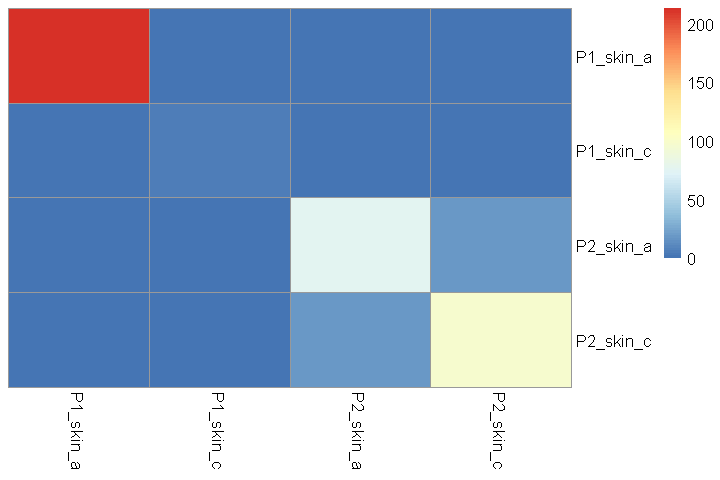

In [18]:
BCR.matrix
pheatmap(BCR.matrix, cluster_rows = FALSE, cluster_cols = FALSE)


### Overlap of cell barcodes between GEX and BCR

P1_skin_a P1_skin_c P2_skin_a P2_skin_c
P1_skin_a 146       2         1         2        
P1_skin_c   9       3         2         1        
P2_skin_a   6       0         1         4        
P2_skin_c   2       0         4         2

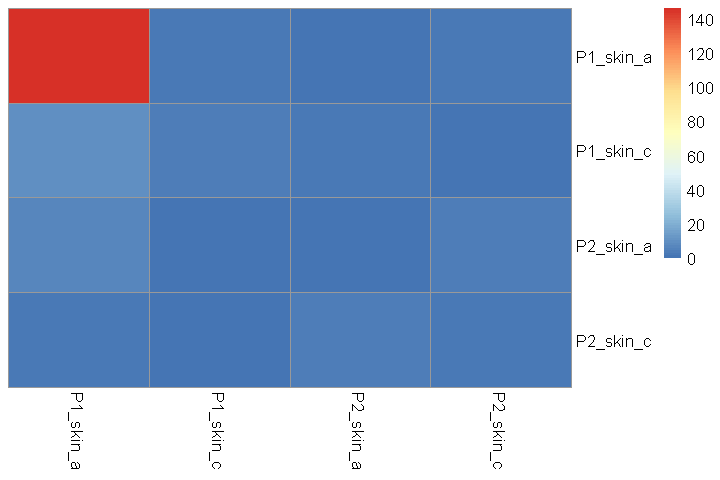

In [19]:
GEX.BCR.matrix
pheatmap(GEX.BCR.matrix, cluster_rows = FALSE, cluster_cols = FALSE)

In [20]:
barcode.GEX.list[[samples[3]]][1:3]
barcode.BCR.list[[samples[3]]][1:3]

[1] "AAACCTGAGATGCGAC" "AAACCTGAGCCAGTTT" "AAACCTGAGGAATGGA"

[1] "AAAGATGAGGCAGGTT" "AAAGATGAGGCAGGTT" "AAAGTAGAGGTGGGTT"

In [21]:
object1 = obj_list[[samples[1]]]
object2 = obj_list[[samples[2]]]
combined <- merge(x= obj_list[[samples[1]]], y=obj_list[[samples[2]]])
for(i in samples[-(1:2)]){
    combined <- merge(x = combined, y = obj_list[[i]]) 
}


Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


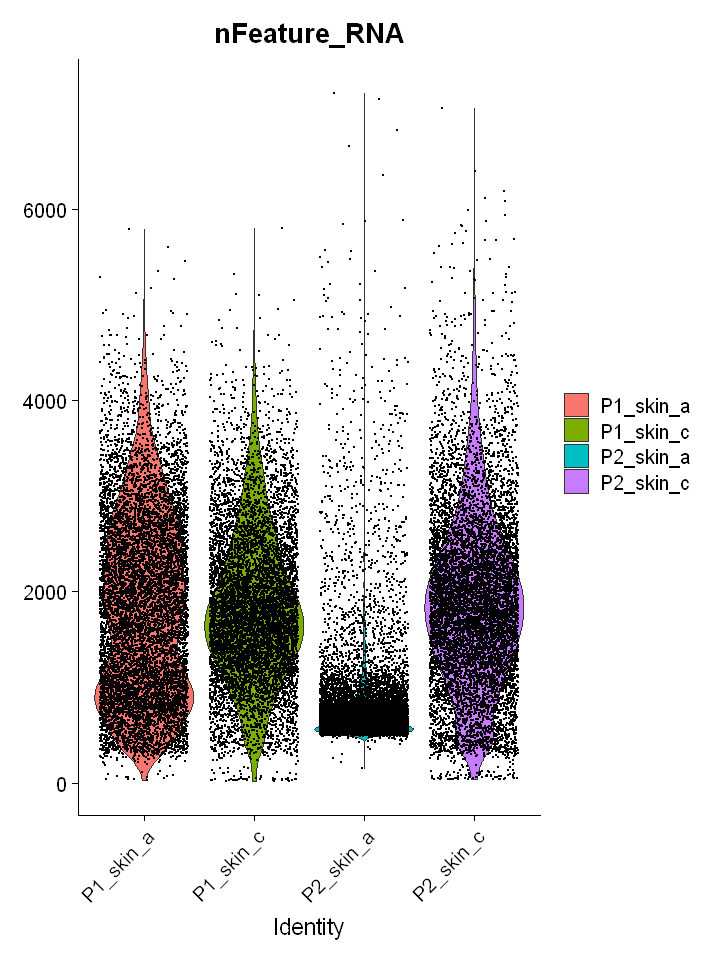

In [22]:
options(repr.plot.width=6, repr.plot.height=8)
#VlnPlot(object = combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
VlnPlot(object = combined, features = "nFeature_RNA")

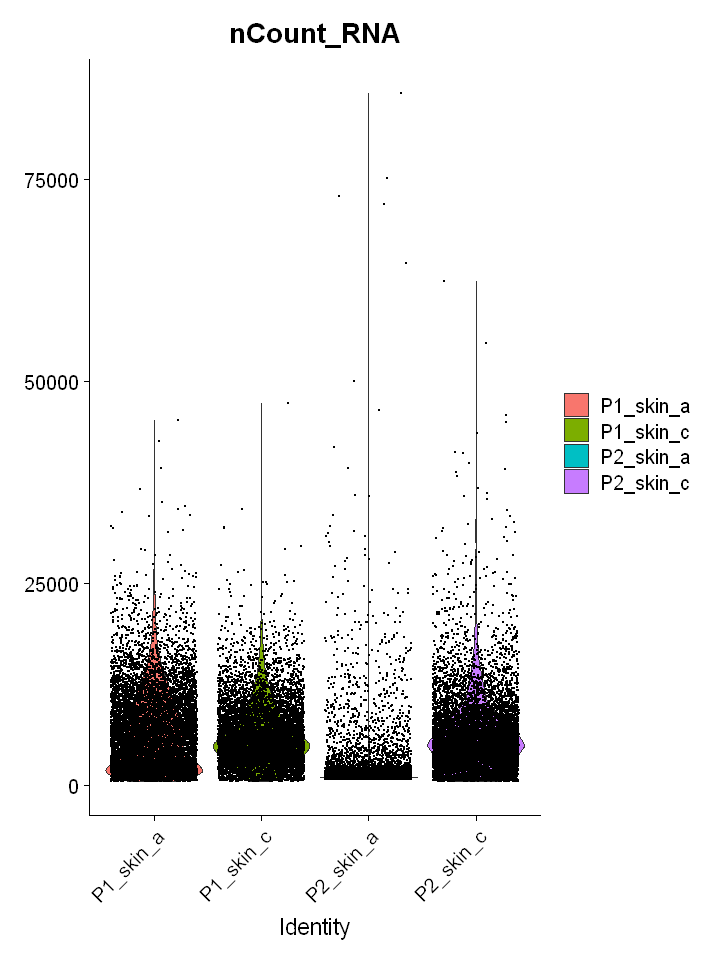

In [23]:
VlnPlot(object = combined, features = "nCount_RNA")

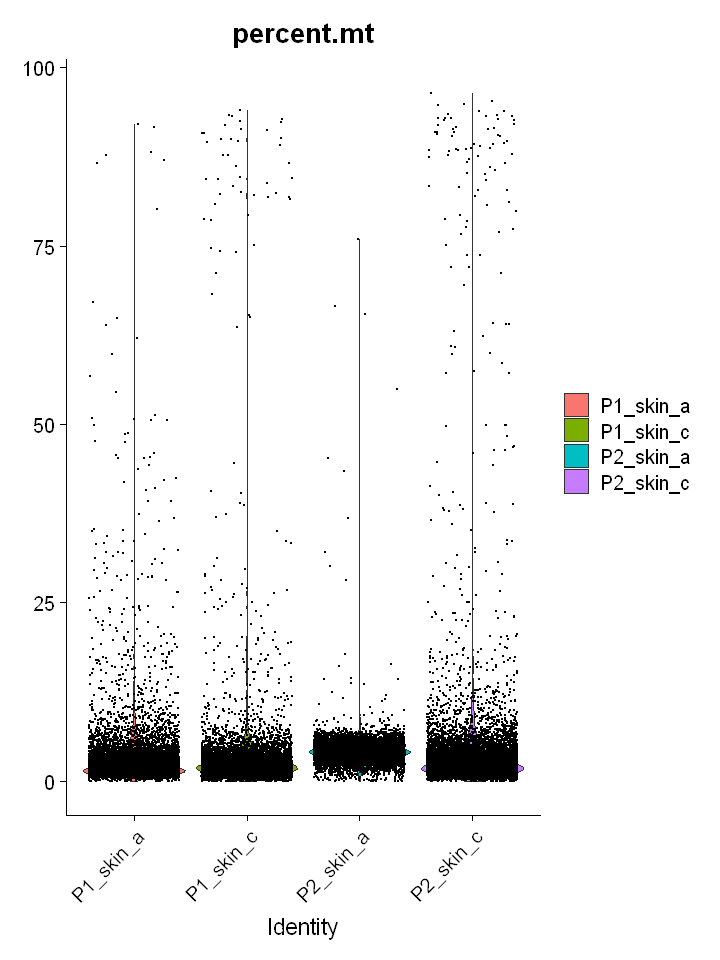

In [24]:
VlnPlot(object = combined, features =  "percent.mt")

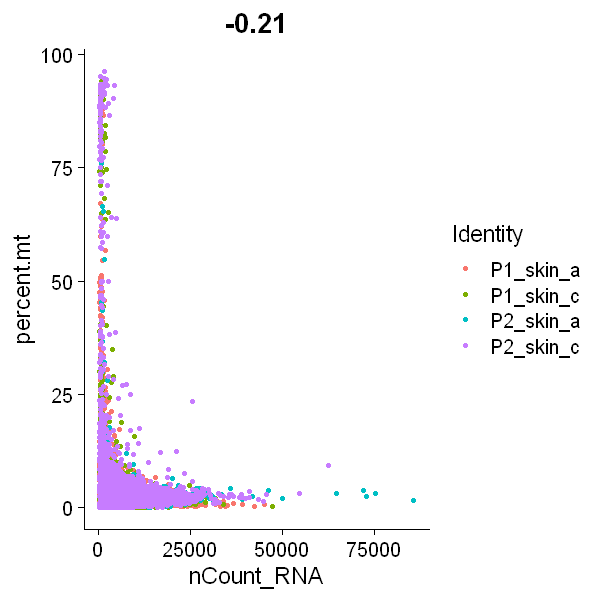

In [25]:
# Low-quality / dying cells often exhibit extensive mitochondrial contamination
options(repr.plot.width=5, repr.plot.height=5)
FeatureScatter(object = combined, feature1 = "nCount_RNA", feature2 = "percent.mt")


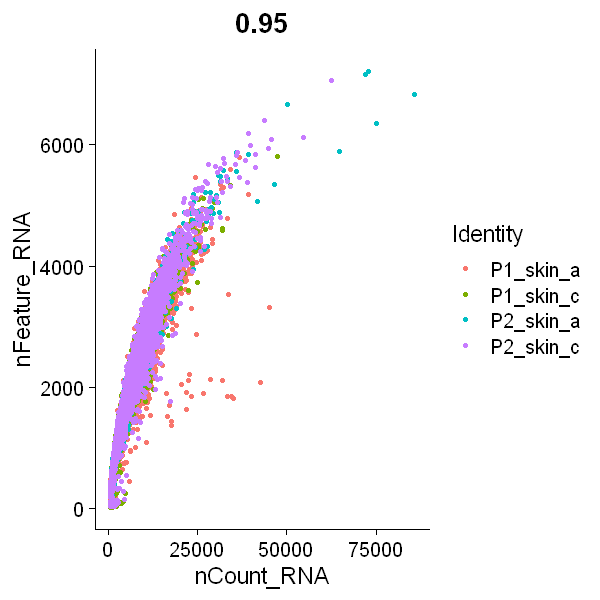

In [26]:
# Low-quality cells or empty droplets will often have very few genes. Cell doublets or multiplets may exhibit an aberrantly high gene count

FeatureScatter(object = combined, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")


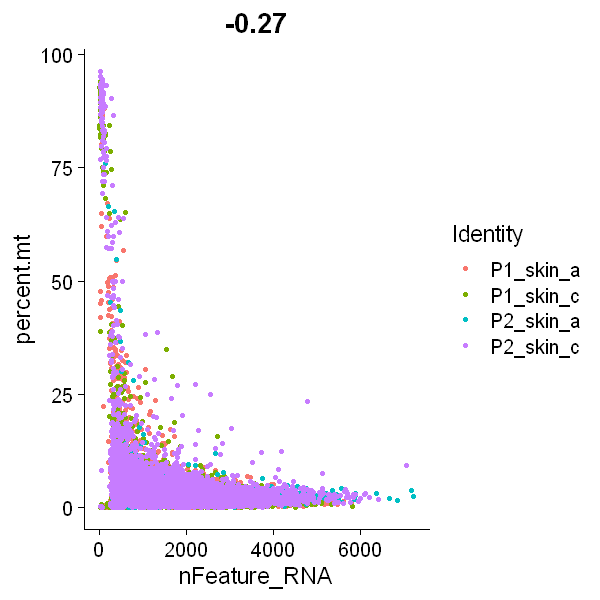

In [27]:
FeatureScatter(object = combined, feature1 = "nFeature_RNA", feature2 = "percent.mt")